In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import pandas as pd
from arch.unitroot import PhillipsPerron
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.regression.linear_model import OLS
from linearmodels.panel import PanelOLS


In [2]:
data = pd.read_csv("dataset.csv")
data_f = data[data['Name'].isin(["France"])].reset_index(drop=True)
data_g = data[data['Name'].isin(["Germany"])].reset_index(drop=True)
del data

### Analysing France Data

In [4]:
data_f = data_f.drop(["Name","country"], axis = 1).set_index('year')

In [5]:
data_f.describe()

,Emission,Pop_density,Agri_percent_land,Cattleperkm,kWh_percapita,Fertilizer,Hydropower
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,7.257641,107.885765,55.988339,38.512798,5641.715474,95.716720,60.990411
std,1.527192,9.511699,2.857462,3.218436,1867.599554,24.522505,8.858099
min,4.238100,90.980848,52.147546,32.488398,1988.336431,59.339076,45.378000
25%,6.545425,100.190295,53.484934,35.995765,4136.196301,72.460737,55.137500
50%,6.935850,107.711193,55.404828,37.707984,6464.394180,98.946102,61.450000
75%,8.177475,116.371608,58.171983,40.364829,7226.640159,118.978180,66.904250
max,10.338800,123.055514,62.094798,43.970970,7734.726783,131.595248,78.790000


In [6]:
print(data_f.isnull().any())

Emission             False
Pop_density          False
Agri_percent_land    False
Cattleperkm          False
kWh_percapita        False
Fertilizer           False
Hydropower           False
dtype: bool


Based on the descriptive statistics and definitions provided, here are some insights about France's data:

Emissions: The average CO2 emissions per capita are 7.26 metric tons, with a relatively low variation (standard deviation of 1.53). The values range from 4.23 to 10.33 metric tons, indicating diverse emission levels across areas.

Population Density: The average population density is 107.88 people per km², with a narrow range between 90.98 and 123.06. This suggests that France has a relatively consistent population spread, with few outliers in density.

Agricultural Land: About 56% of France's total land area is agricultural. The standard deviation of 2.86 implies that most regions have a similar percentage of agricultural land.

Cattle Density: France has an average of 38.51 cattle per km², with a range from 32.49 to 43.97. The low standard deviation (3.22) shows minimal regional variation.

Electric Power Consumption: The average energy consumption per capita is 5641.72 kWh, with significant variation (standard deviation of 1867.6). This could reflect differences in energy usage between rural and urban areas or varying industrial activities.

Fertilizer Use: Fertilizer consumption averages 95.72 kg per capita, with a relatively high variability (standard deviation of 24.52). Some regions may rely more heavily on intensive farming.

Hydropower: Hydropower production is on average 60.99 terawatt-hours, ranging from 45.38 to 78.79. This suggests France leverages its natural resources to produce sustainable energy, with considerable regional differences.

Overall, France demonstrates a balance of industrial activity, agriculture, and energy use, with notable variations in energy consumption and hydropower generation across regions. Let me know if you'd like more detailed analysis or comparisons!

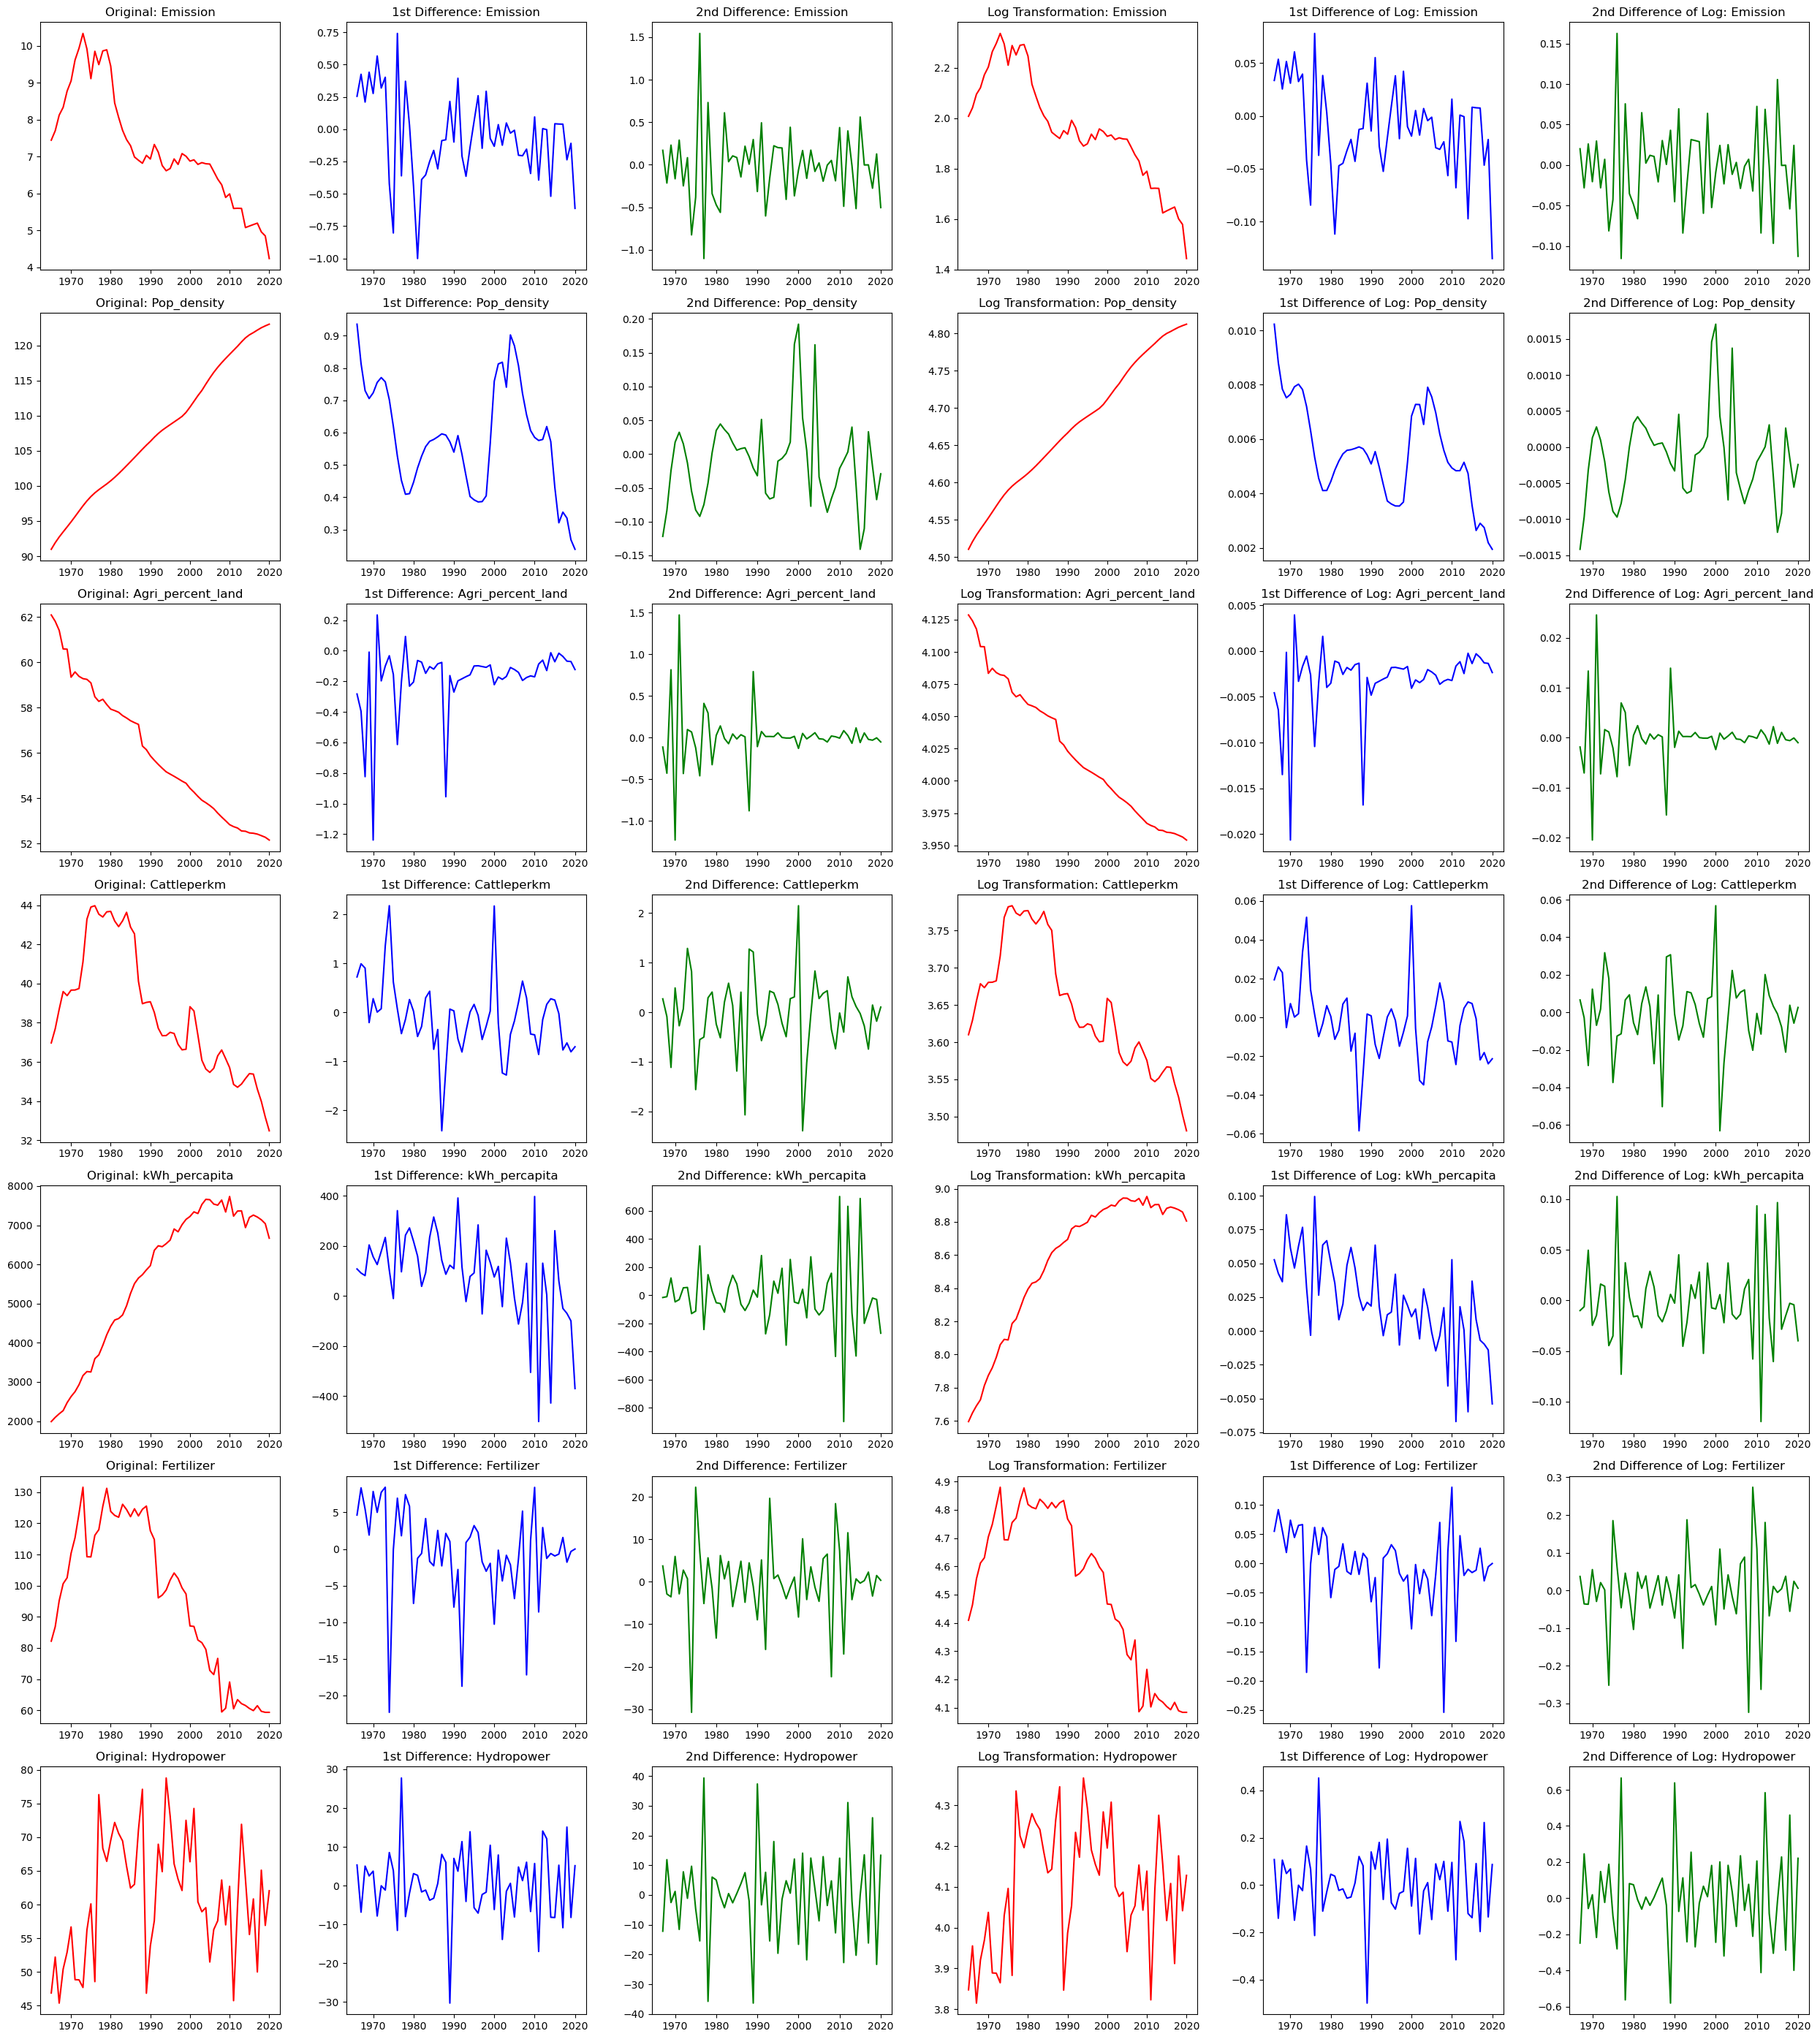

In [8]:
columns = data_f.columns

fig, axes = plt.subplots(len(columns), 6, figsize=(25, len(columns) * 4))

for idx, col in enumerate(columns):
    # Original
    axes[idx, 0].plot(data_f[col], linestyle='-', color='red')
    axes[idx, 0].set_title(f"Original: {col}")

    # 1st Difference
    if len(data_f[col]) > 1:
        axes[idx, 1].plot(data_f[col].diff(), linestyle='-', color='blue')
        axes[idx, 1].set_title(f"1st Difference: {col}")
    else:
        axes[idx, 1].text(0.5, 0.5, 'Insufficient data', ha='center', va='center')

    # 2nd Difference
    if len(data_f[col]) > 2:
        axes[idx, 2].plot(data_f[col].diff().diff(), linestyle='-', color='green')
        axes[idx, 2].set_title(f"2nd Difference: {col}")
    else:
        axes[idx, 2].text(0.5, 0.5, 'Insufficient data', ha='center', va='center')

    # Log Transformation
    positive_values = data_f[col] > 0  # Avoid negative or zero values for log
    if positive_values.sum() > 0:
        log_values = np.log(data_f[col][positive_values])
        axes[idx, 3].plot(log_values, linestyle='-', color='red')
        axes[idx, 3].set_title(f"Log Transformation: {col}")

        # Log 1st Difference
        if len(log_values) > 1:
            axes[idx, 4].plot(log_values.diff(), linestyle='-', color='blue')
            axes[idx, 4].set_title(f"1st Difference of Log: {col}")
        else:
            axes[idx, 4].text(0.5, 0.5, 'Insufficient data', ha='center', va='center')

        # Log 2nd Difference
        if len(log_values) > 2:
            axes[idx, 5].plot(log_values.diff().diff(), linestyle='-', color='green')
            axes[idx, 5].set_title(f"2nd Difference of Log: {col}")
        else:
            axes[idx, 5].text(0.5, 0.5, 'Insufficient data', ha='center', va='center')
    else:
        for i in range(3, 6):
            axes[idx, i].text(0.5, 0.5, 'No positive values', ha='center', va='center')

plt.tight_layout()
plt.savefig("matrix_f.png", dpi=300, bbox_inches='tight')
plt.show()


#### Germany

In [10]:
data_g = data_g.drop(["Name","country"], axis = 1).set_index('year')
data_g.describe()

,Emission,Pop_density,Agri_percent_land,Cattleperkm,kWh_percapita,Fertilizer,Hydropower
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,11.812970,229.509578,50.870024,47.943092,5981.683618,56.136342,18.655321
std,1.585338,5.975823,2.702574,9.836360,1398.095150,17.650888,2.326425
min,7.690100,217.579970,47.498426,32.348331,2194.206061,32.324623,13.206000
25%,10.602200,223.890586,48.584175,37.184599,5733.281716,40.416868,17.422750
50%,11.983600,230.527629,49.671293,47.749555,6492.311624,46.969148,18.525500
75%,13.208225,235.323843,53.304643,57.335067,6913.085395,75.541529,20.096750
max,14.251800,238.024131,55.950506,61.684668,7281.272174,80.848964,23.120000


In [11]:
print(data_g.isnull().any())

Emission             False
Pop_density          False
Agri_percent_land    False
Cattleperkm          False
kWh_percapita        False
Fertilizer           False
Hydropower           False
dtype: bool


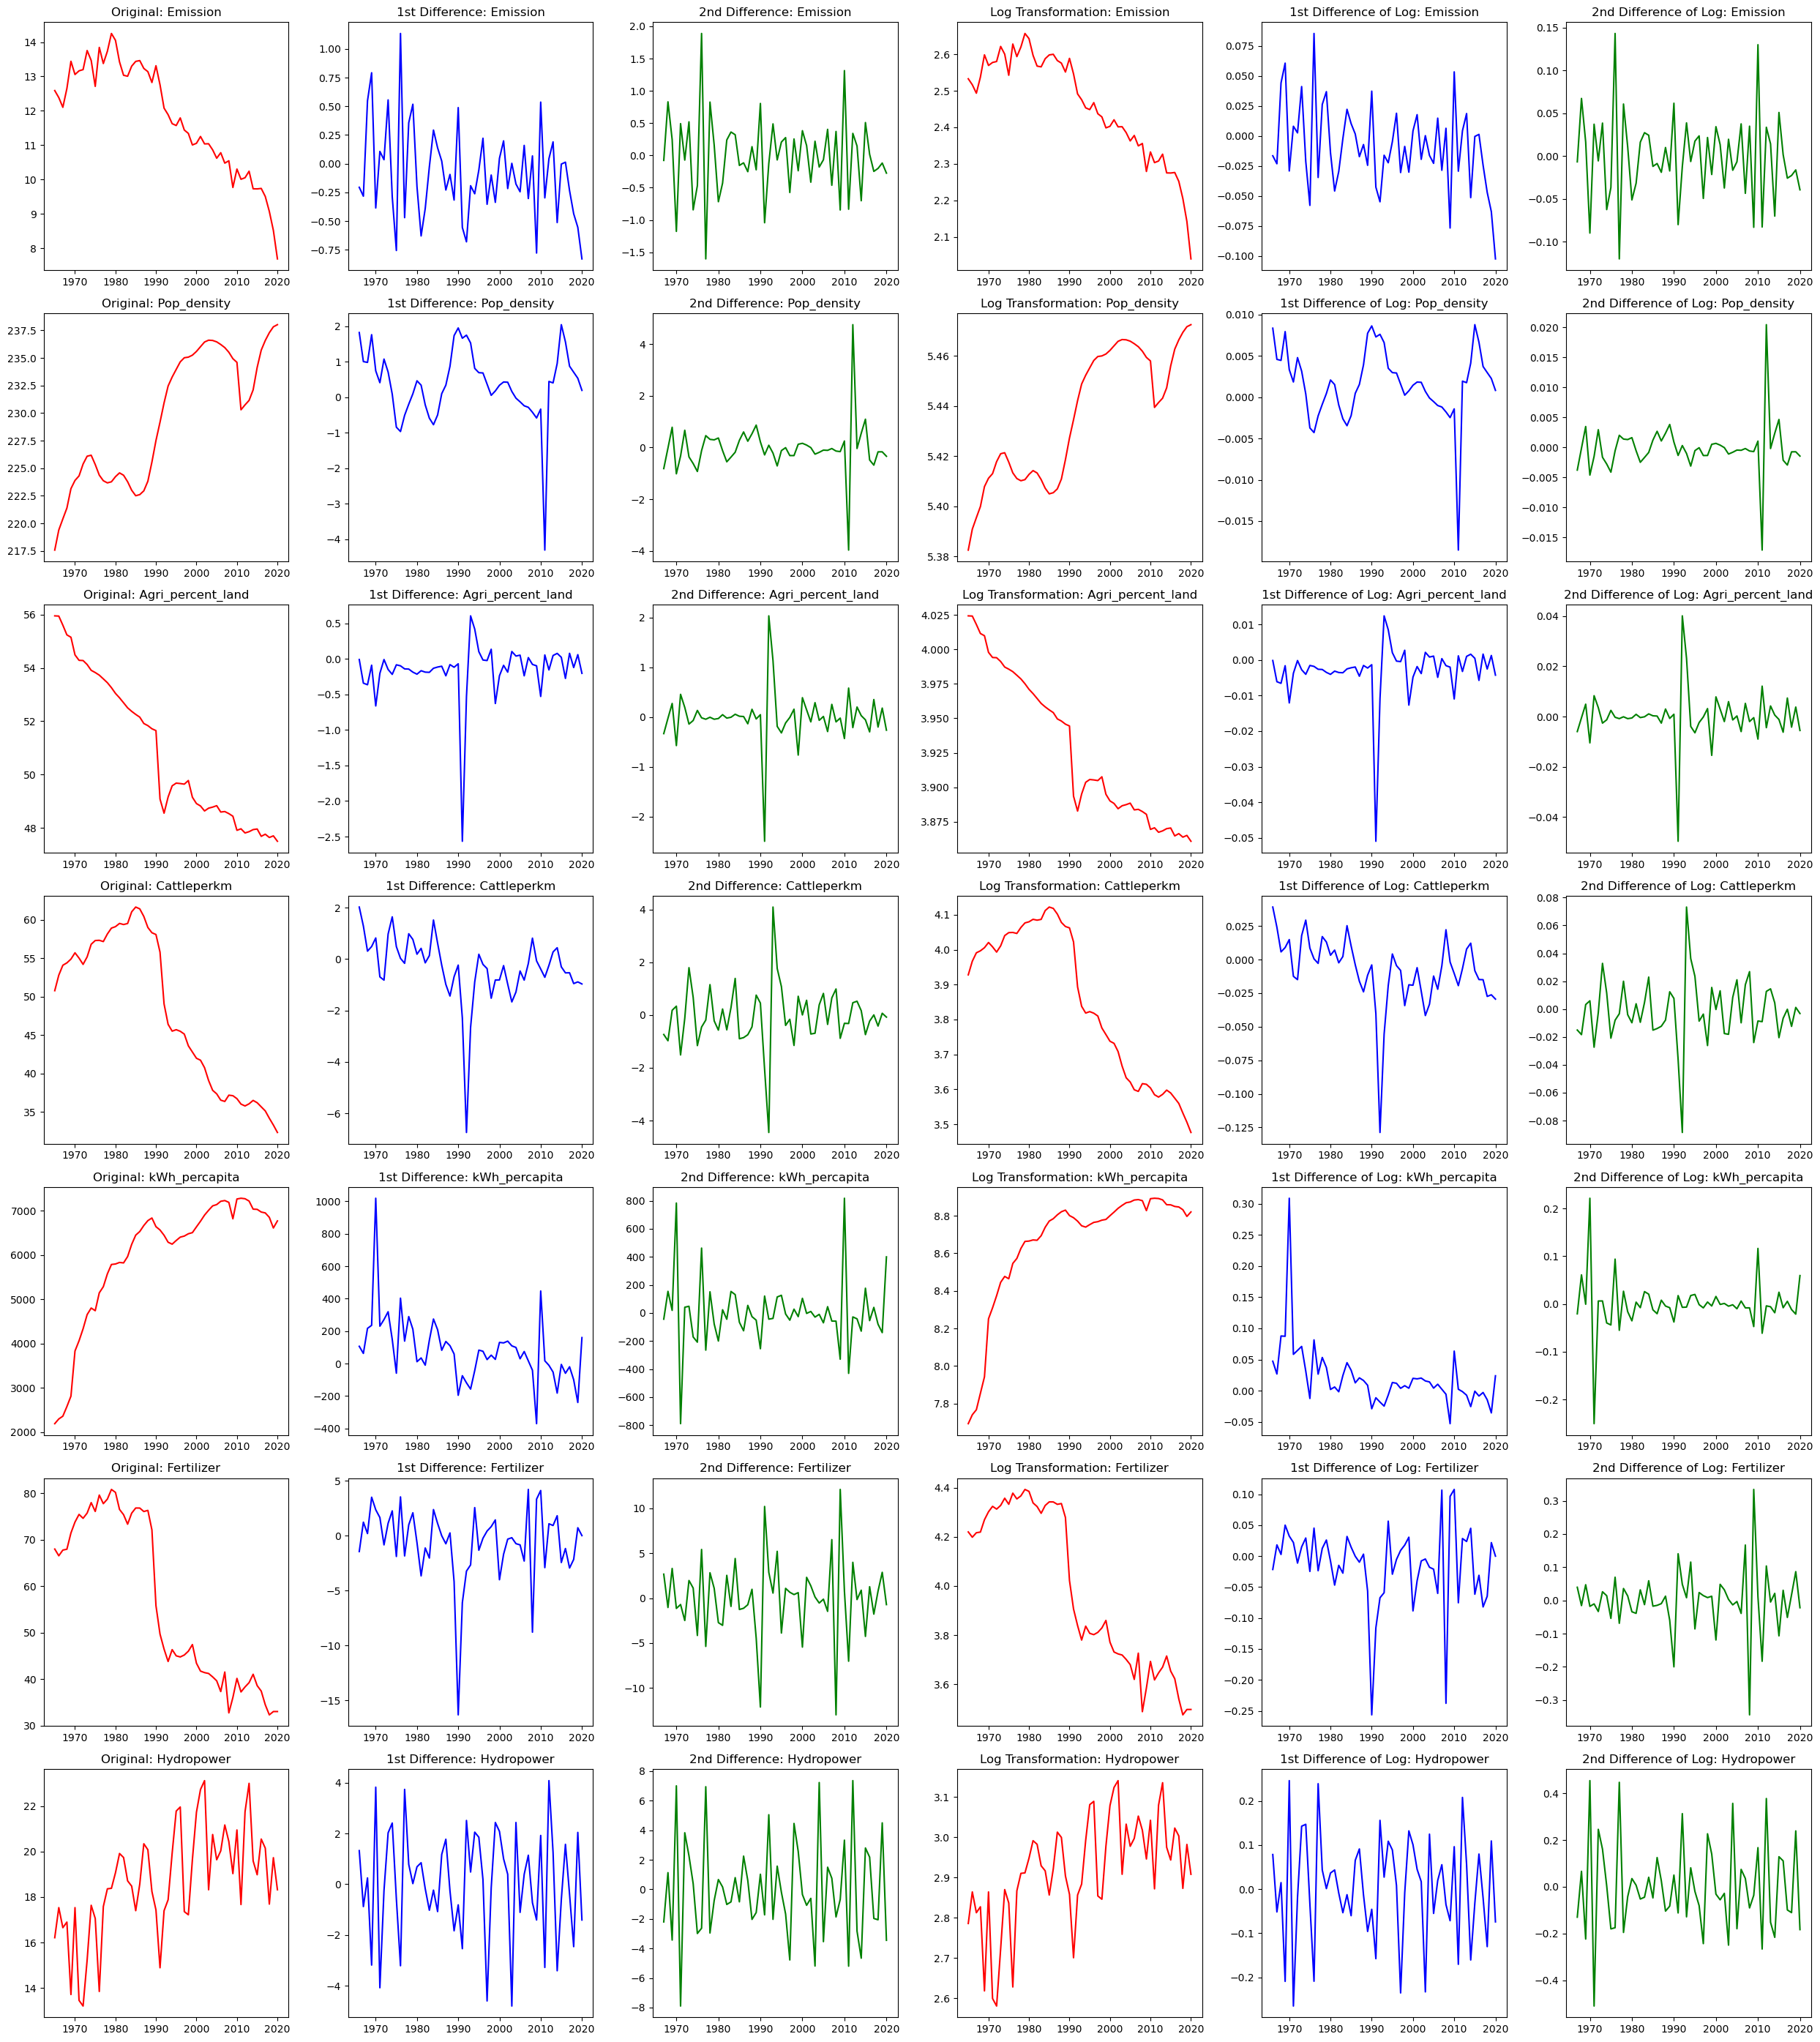

In [12]:
columns = data_g.columns

fig, axes = plt.subplots(len(columns), 6, figsize=(25, len(columns) * 4))

for idx, col in enumerate(columns):
    # Original
    axes[idx, 0].plot(data_g[col], linestyle='-', color='red')
    axes[idx, 0].set_title(f"Original: {col}")

    # 1st Difference
    if len(data_g[col]) > 1:
        axes[idx, 1].plot(data_g[col].diff(), linestyle='-', color='blue')
        axes[idx, 1].set_title(f"1st Difference: {col}")
    else:
        axes[idx, 1].text(0.5, 0.5, 'Insufficient data', ha='center', va='center')

    # 2nd Difference
    if len(data_g[col]) > 2:
        axes[idx, 2].plot(data_g[col].diff().diff(), linestyle='-', color='green')
        axes[idx, 2].set_title(f"2nd Difference: {col}")
    else:
        axes[idx, 2].text(0.5, 0.5, 'Insufficient data', ha='center', va='center')

    # Log Transformation
    positive_values = data_g[col] > 0  # Avoid negative or zero values for log
    if positive_values.sum() > 0:
        log_values = np.log(data_g[col][positive_values])
        axes[idx, 3].plot(log_values, linestyle='-', color='red')
        axes[idx, 3].set_title(f"Log Transformation: {col}")

        # Log 1st Difference
        if len(log_values) > 1:
            axes[idx, 4].plot(log_values.diff(), linestyle='-', color='blue')
            axes[idx, 4].set_title(f"1st Difference of Log: {col}")
        else:
            axes[idx, 4].text(0.5, 0.5, 'Insufficient data', ha='center', va='center')

        # Log 2nd Difference
        if len(log_values) > 2:
            axes[idx, 5].plot(log_values.diff().diff(), linestyle='-', color='green')
            axes[idx, 5].set_title(f"2nd Difference of Log: {col}")
        else:
            axes[idx, 5].text(0.5, 0.5, 'Insufficient data', ha='center', va='center')
    else:
        for i in range(3, 6):
            axes[idx, i].text(0.5, 0.5, 'No positive values', ha='center', va='center')

plt.tight_layout()
plt.savefig("matrix_g.png", dpi=300, bbox_inches='tight')

plt.show()


For France Data
- we see no missing values, nor any strange or abrupt changes in the original data
- Non of the original timeseries are covariance stationary. They all have a deterministic component or a trend or a time-varying mean.
iii)
- - Emission: I(2) is needed for stationarity
- - Pop-density: I(2) is needed for stationarity
- - Agri_percent_land: I(2) is needed for stationarity
- - Cattleperkm :  I(2) is needed for stationarity
- - kWh_Percapita: I(2) is needed for stationarity
- - Fertilizer: I(2) is needed for stationarity
- - Hydropower: I(1) is needed for stationarity

Log Transformation is not necessary for any of the timeseries to be stationary.




For Germany Data
- we see no missing values, nor any strange or abrupt changes in the original data
- Non of the original timeseries are covariance stationary. They all have a deterministic component or a trend or a time-varying mean.
iii)
- - Emission: I(2) is needed for stationarity
- - Pop-density: I(2) is needed for stationarity
- - Agri_percent_land: I(2) is needed for stationarity
- - Cattleperkm :  I(2) is needed for stationarity
- - kWh_Percapita: Log Transformation + I(2) is needed for stationarity
- - Fertilizer: I(2) is needed for stationarity
- - Hydropower: I(1) is needed for stationarity


### Question 3

### France Data

In [16]:
data_f.head(10)

,Emission,Pop_density,Agri_percent_land,Cattleperkm,kWh_percapita,Fertilizer,Hydropower
year,,,,,,,
1965,7.4459,90.980848,62.094798,36.970710,1988.336431,82.186699,46.881
1966,7.7003,91.916350,61.811727,37.694641,2095.697416,86.823939,52.208
1967,8.1250,92.729987,61.415428,38.687398,2186.790028,95.173068,45.378
1968,8.3349,93.459979,60.591783,39.591589,2267.666791,100.631964,50.423
1969,8.7758,94.165512,60.582651,39.384301,2470.974850,102.538770,52.942
1970,9.0522,94.888556,59.344444,39.665165,2626.923443,110.401131,56.681
1971,9.6185,95.643849,59.578206,39.671945,2751.886709,115.408127,48.857
1972,9.9369,96.414224,59.380970,39.746982,2929.642106,123.155508,48.831
1973,10.3388,97.171380,59.280525,41.106657,3162.773292,131.595248,47.696


In [17]:


# Define functions for ADF, KPSS, and Phillips-Perron tests
def adf_test(series, regression):
    result = adfuller(series, autolag='AIC', regression=regression)
    return result[0], result[1]  # Test statistic and p-value

def kpss_test(series, regression):
    result = kpss(series, regression=regression, nlags="auto")
    return result[0], result[1]  # Test statistic and p-value

def pp_test(series, trend):
    result = PhillipsPerron(series, trend=trend)
    return result.stat, result.pvalue  # Test statistic and p-value

# Placeholder for results
adf_p_values = []
adf_test_statistics = []
kpss_p_values = []
kpss_test_statistics = []
pp_p_values = []
pp_test_statistics = []

# Apply tests to each column
for col in data_f.columns:
    # Original series (I(0)) - Include constant + trend
    adf_stat_0, adf_pvalue_0 = adf_test(data_f[col], regression='ct')
    kpss_stat_0, kpss_pvalue_0 = kpss_test(data_f[col], regression='ct')
    pp_stat_0, pp_pvalue_0 = pp_test(data_f[col], trend='ct')

    # First difference (I(1)) - Include constant only for specific time series
    diff_1 = data_f[col].diff().dropna()
    if col in ['Emission', 'Pop_density', 'kWh_percapita', 'Agri_percent_land']:
        adf_stat_1, adf_pvalue_1 = adf_test(diff_1, regression='c')
        kpss_stat_1, kpss_pvalue_1 = kpss_test(diff_1, regression='c')
        pp_stat_1, pp_pvalue_1 = pp_test(diff_1, trend='c')
    else:
        adf_stat_1, adf_pvalue_1 = adf_test(diff_1, regression='n')
        kpss_stat_1, kpss_pvalue_1 = kpss_test(diff_1, regression='c')  # KPSS always needs at least constant
        pp_stat_1, pp_pvalue_1 = pp_test(diff_1, trend='n')

    # Second difference (I(2)) - Do not include any deterministic components
    diff_2 = diff_1.diff().dropna()
    adf_stat_2, adf_pvalue_2 = adf_test(diff_2, regression='n')
    kpss_stat_2, kpss_pvalue_2 = kpss_test(diff_2, regression='c')  # Minimum regression for KPSS
    pp_stat_2, pp_pvalue_2 = pp_test(diff_2, trend='n')

    # Append results
    adf_p_values.append([adf_pvalue_0, adf_pvalue_1, adf_pvalue_2])
    adf_test_statistics.append([adf_stat_0, adf_stat_1, adf_stat_2])
    kpss_p_values.append([kpss_pvalue_0, kpss_pvalue_1, kpss_pvalue_2])
    kpss_test_statistics.append([kpss_stat_0, kpss_stat_1, kpss_stat_2])
    pp_p_values.append([pp_pvalue_0, pp_pvalue_1, pp_pvalue_2])
    pp_test_statistics.append([pp_stat_0, pp_stat_1, pp_stat_2])

# Create dataframes for p-values and test statistics
adf_p_values_df = pd.DataFrame(np.round(adf_p_values, 4), columns=['I(0)', 'I(1)', 'I(2)'], index=data_f.columns)
adf_test_statistics_df = pd.DataFrame(np.round(adf_test_statistics, 4), columns=['I(0)', 'I(1)', 'I(2)'], index=data_f.columns)
kpss_p_values_df = pd.DataFrame(np.round(kpss_p_values, 4), columns=['I(0)', 'I(1)', 'I(2)'], index=data_f.columns)
kpss_test_statistics_df = pd.DataFrame(np.round(kpss_test_statistics, 4), columns=['I(0)', 'I(1)', 'I(2)'], index=data_f.columns)
pp_p_values_df = pd.DataFrame(np.round(pp_p_values, 4), columns=['I(0)', 'I(1)', 'I(2)'], index=data_f.columns)
pp_test_statistics_df = pd.DataFrame(np.round(pp_test_statistics, 4), columns=['I(0)', 'I(1)', 'I(2)'], index=data_f.columns)

# Output the results
print("ADF P-Values DataFrame:")
print(adf_p_values_df)
print("\nADF Test Statistics DataFrame:")
print(adf_test_statistics_df)
print("\nKPSS P-Values DataFrame:")
print(kpss_p_values_df)
print("\nKPSS Test Statistics DataFrame:")
print(kpss_test_statistics_df)
print("\nPhillips-Perron P-Values DataFrame:")
print(pp_p_values_df)
print("\nPhillips-Perron Test Statistics DataFrame:")
print(pp_test_statistics_df)

ADF P-Values DataFrame:
                     I(0)    I(1)    I(2)
Emission           0.0170  0.0048  0.0023
Pop_density        0.2065  0.1192  0.0000
Agri_percent_land  0.2635  0.0000  0.0000
Cattleperkm        0.0058  0.0000  0.0000
kWh_percapita      1.0000  0.9565  0.0856
Fertilizer         0.0698  0.0000  0.0000
Hydropower         0.0009  0.0000  0.0000

ADF Test Statistics DataFrame:
                     I(0)    I(1)    I(2)
Emission          -3.7914 -3.6550 -3.0458
Pop_density       -2.7745 -2.4849 -4.5177
Agri_percent_land -2.6363 -8.5489 -6.3370
Cattleperkm       -4.1270 -4.7435 -6.3913
kWh_percapita      2.3428 -0.0236 -1.6934
Fertilizer        -3.2790 -7.3312 -5.0939
Hydropower        -4.6449 -6.3213 -6.5150

KPSS P-Values DataFrame:
                     I(0)    I(1)    I(2)
Emission           0.1000  0.1000  0.1000
Pop_density        0.1000  0.1000  0.1000
Agri_percent_land  0.0100  0.0390  0.1000
Cattleperkm        0.0406  0.0804  0.1000
kWh_percapita      0.0100  0.0100  0

# Germany

In [19]:

# Define functions for ADF, KPSS, and Phillips-Perron tests
def adf_test(series, regression):
    result = adfuller(series, autolag='AIC', regression=regression)
    return result[0], result[1]  # Test statistic and p-value

def kpss_test(series, regression):
    result = kpss(series, regression=regression, nlags="auto")
    return result[0], result[1]  # Test statistic and p-value

def pp_test(series, trend):
    result = PhillipsPerron(series, trend=trend)
    return result.stat, result.pvalue  # Test statistic and p-value

# Placeholder for results
adf_p_values = []
adf_test_statistics = []
kpss_p_values = []
kpss_test_statistics = []
pp_p_values = []
pp_test_statistics = []

# Apply tests to each column
for col in data_g.columns:
    # Original series (I(0)) - Include constant + trend
    adf_stat_0, adf_pvalue_0 = adf_test(data_g[col], regression='ct')
    kpss_stat_0, kpss_pvalue_0 = kpss_test(data_g[col], regression='ct')
    pp_stat_0, pp_pvalue_0 = pp_test(data_g[col], trend='ct')

    # First difference (I(1)) - Include constant only for specific time series
    diff_1 = data_g[col].diff().dropna()
    if col in ['Emission', 'Pop_density', 'kWh_percapita', 'Agri_percent_land']:
        adf_stat_1, adf_pvalue_1 = adf_test(diff_1, regression='c')
        kpss_stat_1, kpss_pvalue_1 = kpss_test(diff_1, regression='c')
        pp_stat_1, pp_pvalue_1 = pp_test(diff_1, trend='c')
    else:
        adf_stat_1, adf_pvalue_1 = adf_test(diff_1, regression='n')
        kpss_stat_1, kpss_pvalue_1 = kpss_test(diff_1, regression='c')  # KPSS always needs at least constant
        pp_stat_1, pp_pvalue_1 = pp_test(diff_1, trend='n')

    # Second difference (I(2)) - Do not include any deterministic components
    diff_2 = diff_1.diff().dropna()
    adf_stat_2, adf_pvalue_2 = adf_test(diff_2, regression='n')
    kpss_stat_2, kpss_pvalue_2 = kpss_test(diff_2, regression='c')  # Minimum regression for KPSS
    pp_stat_2, pp_pvalue_2 = pp_test(diff_2, trend='n')

    # Append results
    adf_p_values.append([adf_pvalue_0, adf_pvalue_1, adf_pvalue_2])
    adf_test_statistics.append([adf_stat_0, adf_stat_1, adf_stat_2])
    kpss_p_values.append([kpss_pvalue_0, kpss_pvalue_1, kpss_pvalue_2])
    kpss_test_statistics.append([kpss_stat_0, kpss_stat_1, kpss_stat_2])
    pp_p_values.append([pp_pvalue_0, pp_pvalue_1, pp_pvalue_2])
    pp_test_statistics.append([pp_stat_0, pp_stat_1, pp_stat_2])

# Create dataframes for p-values and test statistics
adf_p_values_df = pd.DataFrame(np.round(adf_p_values, 4), columns=['I(0)', 'I(1)', 'I(2)'], index=data_g.columns)
adf_test_statistics_df = pd.DataFrame(np.round(adf_test_statistics, 4), columns=['I(0)', 'I(1)', 'I(2)'], index=data_g.columns)
kpss_p_values_df = pd.DataFrame(np.round(kpss_p_values, 4), columns=['I(0)', 'I(1)', 'I(2)'], index=data_g.columns)
kpss_test_statistics_df = pd.DataFrame(np.round(kpss_test_statistics, 4), columns=['I(0)', 'I(1)', 'I(2)'], index=data_g.columns)
pp_p_values_df = pd.DataFrame(np.round(pp_p_values, 4), columns=['I(0)', 'I(1)', 'I(2)'], index=data_g.columns)
pp_test_statistics_df = pd.DataFrame(np.round(pp_test_statistics, 4), columns=['I(0)', 'I(1)', 'I(2)'], index=data_g.columns)

# Output the results
print("ADF P-Values DataFrame:")
print(adf_p_values_df)
print("\nADF Test Statistics DataFrame:")
print(adf_test_statistics_df)
print("\nKPSS P-Values DataFrame:")
print(kpss_p_values_df)
print("\nKPSS Test Statistics DataFrame:")
print(kpss_test_statistics_df)
print("\nPhillips-Perron P-Values DataFrame:")
print(pp_p_values_df)
print("\nPhillips-Perron Test Statistics DataFrame:")
print(pp_test_statistics_df)

ADF P-Values DataFrame:
                     I(0)    I(1)    I(2)
Emission           0.6341  0.0000  0.2262
Pop_density        0.1731  0.0009  0.0000
Agri_percent_land  0.3155  0.0000  0.0000
Cattleperkm        0.5186  0.0002  0.0000
kWh_percapita      0.6382  0.0000  0.0000
Fertilizer         0.5729  0.0000  0.0000
Hydropower         0.0005  0.0000  0.0000

ADF Test Statistics DataFrame:
                     I(0)    I(1)     I(2)
Emission          -1.9393 -8.1112  -1.1545
Pop_density       -2.8680 -4.1287 -10.5914
Agri_percent_land -2.5252 -5.9217  -5.3314
Cattleperkm       -2.1489 -3.6927  -6.7940
kWh_percapita     -1.9315 -5.3692  -6.6764
Fertilizer        -2.0519 -5.9620  -8.3986
Hydropower        -4.7863 -5.8210  -5.8440

KPSS P-Values DataFrame:
                     I(0)    I(1)    I(2)
Emission           0.0100  0.0435  0.0974
Pop_density        0.1000  0.1000  0.1000
Agri_percent_land  0.0100  0.1000  0.0821
Cattleperkm        0.0151  0.0711  0.1000
kWh_percapita      0.0100  0

- For the original time series we used Constant+Trend regression
- For the I(1) time series, we used Constant regression for Emission, Pop_density, kWh_percapita, Agri_percent_land
- For the I(2) time series, we did not use constant nor trend as all the time series were centered around 0

### Question 4



The type of cointegrating relationships expected between the variables can be drawn from previous literature, particularly the findings of Perone (2024). Renewable energy sources like hydropower, solar, wind, biofuel, and geothermal energy are anticipated to exhibit a **negative long-run relationship** with CO2 emissions due to their potential to replace fossil fuels and reduce greenhouse gas emissions. This implies that an increase in renewable energy production should lead to a decrease in CO2 emissions over time.

Control variables, such as population density, energy consumption, and agricultural land use, might also show cointegrating relationships with CO2 emissions. For instance:
- **Population density**: Higher density can have mixed effects on emissions, depending on urbanization and infrastructure efficiency.
- **Energy consumption**: Non-renewable energy use is expected to be positively correlated with emissions.
- **Agricultural land use**: Agricultural expansion, especially livestock activities, contributes to emissions and might share a positive cointegrating relationship.

The relationships are expected to vary depending on the specific renewable energy source. For example:
- Hydropower, solar, and wind energy are likely to show the strongest negative cointegration with emissions, as identified in Perone's study.
- Biofuel and geothermal energy may show weaker but still significant relationships.

This aligns with the expectation that renewable energy sources, particularly hydropower and solar, are critical in achieving sustainability and mitigating climate change impacts.

### France

In [24]:
# Define Engle-Granger Test for Cointegration
def engle_granger_test(y, x):
    model = sm.OLS(y, sm.add_constant(x)).fit()
    residuals = model.resid
    adf_result = adfuller(residuals, regression='n')  # No deterministic trend
    print(f"Engle-Granger Test (y vs x):")
    print(f"ADF Statistic: {adf_result[0]}, p-value: {adf_result[1]}")
    if adf_result[1] < 0.05:
        print("Residuals are stationary. Evidence of cointegration.")
    else:
        print("No evidence of cointegration.")
    print()

# Define Phillips-Ouliaris Test
def phillips_ouliaris_test(y, x):
    stat, p_value, _ = coint(y, x)
    print(f"Phillips-Ouliaris Test (y vs x):")
    print(f"Test Statistic: {stat}, p-value: {p_value}")
    if p_value < 0.05:
        print("Evidence of cointegration.")
    else:
        print("No evidence of cointegration.")
    print()

# Define Johansen Test
def johansen_test(data_matrix):
    johansen_result = coint_johansen(data_matrix, det_order=0, k_ar_diff=1)
    print("Johansen Test Results:")

    # Trace Test
    print(f"Trace Statistics: {johansen_result.lr1}")
    print(f"Critical Values (5%): {johansen_result.cvt[:, 1]}")

    # Max Eigenvalue Test
    print(f"Max Eigenvalue Statistics: {johansen_result.lr2}")

    print("\nTrace Test Results:")
    for i, stat in enumerate(johansen_result.lr1):
        if stat > johansen_result.cvt[i, 1]:
            print(f"Cointegrating vector {i+1} exists (Trace Test).")
        else:
            print(f"No cointegration for vector {i+1} (Trace Test).")

    print("\nMax Eigenvalue Test Results:")
    for i, stat in enumerate(johansen_result.lr2):
        if stat > johansen_result.cvm[i, 1]:
            print(f"Cointegrating vector {i+1} exists (Max Eigenvalue Test).")
        else:
            print(f"No cointegration for vector {i+1} (Max Eigenvalue Test).")
    print()

# Main Code to Perform Tests for First Differences (I(1) Series)
# Independent variables to test with Emission
independent_vars = ['Hydropower', 'kWh_percapita', 'Fertilizer', 'Cattleperkm', 'Agri_percent_land', 'Pop_density']

# Difference all variables to make them stationary
data_f_diff = data_f.diff().dropna()

# Engle-Granger and Phillips-Ouliaris Tests on First Differences
print("Performing Engle-Granger and Phillips-Ouliaris Tests on Differenced Data...\n")
for var in independent_vars:
    print(f"Testing Emission and {var} (Engle-Granger):")
    engle_granger_test(data_f_diff['Emission'], data_f_diff[var])
    
    print(f"Testing Emission and {var} (Phillips-Ouliaris):")
    phillips_ouliaris_test(data_f_diff['Emission'], data_f_diff[var])

# Johansen Test for First Differences
subset_vars = ['Emission', 'Hydropower', 'kWh_percapita', 'Fertilizer']
data_matrix = data_f_diff[subset_vars].dropna().values
print("\nPerforming Johansen Test for Differenced Data (First Differences):")
johansen_test(data_matrix)


Performing Engle-Granger and Phillips-Ouliaris Tests on Differenced Data...

Testing Emission and Hydropower (Engle-Granger):
Engle-Granger Test (y vs x):
ADF Statistic: -5.653964193751359, p-value: 5.0402390443228964e-08
Residuals are stationary. Evidence of cointegration.

Testing Emission and Hydropower (Phillips-Ouliaris):
Phillips-Ouliaris Test (y vs x):
Test Statistic: -5.653964193751359, p-value: 8.712647458093685e-06
Evidence of cointegration.

Testing Emission and kWh_percapita (Engle-Granger):
Engle-Granger Test (y vs x):
ADF Statistic: -2.981132157693622, p-value: 0.002830051788172136
Residuals are stationary. Evidence of cointegration.

Testing Emission and kWh_percapita (Phillips-Ouliaris):
Phillips-Ouliaris Test (y vs x):
Test Statistic: -2.9811321576936214, p-value: 0.1147587637596108
No evidence of cointegration.

Testing Emission and Fertilizer (Engle-Granger):
Engle-Granger Test (y vs x):
ADF Statistic: -3.30793256823502, p-value: 0.0009527658809648094
Residuals are s

Key Insights:
Hydropower, Cattleperkm, and Agri_percent_land are strongly linked to emissions, making them crucial targets for long-term policy interventions.
Mixed results for kWh_percapita, Fertilizer, and Pop_density require further investigation or expanded models.
The Johansen test suggests emissions are influenced by a combination of renewable energy, agriculture, and land use factors in the long run.

### Germany

In [27]:
# Define Engle-Granger Test for Cointegration
def engle_granger_test(y, x):
    model = sm.OLS(y, sm.add_constant(x)).fit()
    residuals = model.resid
    adf_result = adfuller(residuals, regression='n')  # No deterministic trend
    print(f"Engle-Granger Test (y vs x):")
    print(f"ADF Statistic: {adf_result[0]}, p-value: {adf_result[1]}")
    if adf_result[1] < 0.05:
        print("Residuals are stationary. Evidence of cointegration.")
    else:
        print("No evidence of cointegration.")
    print()

# Define Phillips-Ouliaris Test
def phillips_ouliaris_test(y, x):
    stat, p_value, _ = coint(y, x)
    print(f"Phillips-Ouliaris Test (y vs x):")
    print(f"Test Statistic: {stat}, p-value: {p_value}")
    if p_value < 0.05:
        print("Evidence of cointegration.")
    else:
        print("No evidence of cointegration.")
    print()

# Define Johansen Test
def johansen_test(data_matrix):
    johansen_result = coint_johansen(data_matrix, det_order=0, k_ar_diff=1)
    print("Johansen Test Results:")

    # Trace Test
    print(f"Trace Statistics: {johansen_result.lr1}")
    print(f"Critical Values (5%): {johansen_result.cvt[:, 1]}")

    # Max Eigenvalue Test
    print(f"Max Eigenvalue Statistics: {johansen_result.lr2}")

    print("\nTrace Test Results:")
    for i, stat in enumerate(johansen_result.lr1):
        if stat > johansen_result.cvt[i, 1]:
            print(f"Cointegrating vector {i+1} exists (Trace Test).")
        else:
            print(f"No cointegration for vector {i+1} (Trace Test).")

    print("\nMax Eigenvalue Test Results:")
    for i, stat in enumerate(johansen_result.lr2):
        if stat > johansen_result.cvm[i, 1]:
            print(f"Cointegrating vector {i+1} exists (Max Eigenvalue Test).")
        else:
            print(f"No cointegration for vector {i+1} (Max Eigenvalue Test).")
    print()

# Main Code to Perform Tests for First Differences (I(1) Series)
# Independent variables to test with Emission
independent_vars = ['Hydropower', 'kWh_percapita', 'Fertilizer', 'Cattleperkm', 'Agri_percent_land', 'Pop_density']

# Difference all variables to make them stationary
data_g_diff = data_g.diff().dropna()

# Engle-Granger and Phillips-Ouliaris Tests on First Differences
print("Performing Engle-Granger and Phillips-Ouliaris Tests on Differenced Data...\n")
for var in independent_vars:
    print(f"Testing Emission and {var} (Engle-Granger):")
    engle_granger_test(data_g_diff['Emission'], data_g_diff[var])
    
    print(f"Testing Emission and {var} (Phillips-Ouliaris):")
    phillips_ouliaris_test(data_g_diff['Emission'], data_g_diff[var])

# Johansen Test for First Differences
subset_vars = ['Emission', 'Hydropower', 'kWh_percapita', 'Fertilizer']
data_matrix = data_g_diff[subset_vars].dropna().values
print("\nPerforming Johansen Test for Differenced Data (First Differences):")
johansen_test(data_matrix)


Performing Engle-Granger and Phillips-Ouliaris Tests on Differenced Data...

Testing Emission and Hydropower (Engle-Granger):
Engle-Granger Test (y vs x):
ADF Statistic: -8.144197626717435, p-value: 1.537233953615642e-13
Residuals are stationary. Evidence of cointegration.

Testing Emission and Hydropower (Phillips-Ouliaris):
Phillips-Ouliaris Test (y vs x):
Test Statistic: -8.144197626717434, p-value: 1.3100374157790844e-11
Evidence of cointegration.

Testing Emission and kWh_percapita (Engle-Granger):
Engle-Granger Test (y vs x):
ADF Statistic: -1.8832102174185794, p-value: 0.0568943126394778
No evidence of cointegration.

Testing Emission and kWh_percapita (Phillips-Ouliaris):
Phillips-Ouliaris Test (y vs x):
Test Statistic: -1.8832102174185814, p-value: 0.5884975810692895
No evidence of cointegration.

Testing Emission and Fertilizer (Engle-Granger):
Engle-Granger Test (y vs x):
ADF Statistic: -8.453048034813765, p-value: 3.029208923664876e-14
Residuals are stationary. Evidence of 

Key Insights
Strong Pairwise Cointegration:

Hydropower, Fertilizer, Cattleperkm, Agri_percent_land, and Pop_density have robust long-run relationships with Emission.
These variables are crucial for policy targeting emissions reductions.
No Pairwise Cointegration:

kWh_percapita shows no significant long-run relationship with Emission. This suggests energy consumption per capita may not directly impact emissions in the dataset.
System-Wide Cointegration:

The Johansen test confirms multiple cointegrating vectors, indicating that emissions are influenced by a combination of factors, including renewable energy, agriculture, and population density.
Policy Implications:

Policies should focus on reducing agricultural emissions (Cattleperkm, Fertilizer) and enhancing renewable energy (Hydropower).
Urbanization (Pop_density) and land use (Agri_percent_land) are also significant factors to consider.

## Q.4.4

In [30]:
import pandas as pd
import statsmodels.api as sm

# Define the ECM Model
def error_correction_model(y, x):
    # OLS to get residuals
    ols_model = sm.OLS(y, sm.add_constant(x)).fit()
    residuals = ols_model.resid

    # Prepare ECM data
    ecm_data = pd.DataFrame({
        'dy': y.diff(),
        'dx': x.diff(),
        'lagged_residual': residuals.shift(1)
    }).dropna()

    # Fit ECM
    ecm_model = sm.OLS(ecm_data['dy'], sm.add_constant(ecm_data[['dx', 'lagged_residual']])).fit()
    return ecm_model

# Define DOLS Model
def dynamic_ols(y, x, lags=1, leads=1):
    df = pd.concat([y, x], axis=1).dropna()
    df['lead_x'] = df[x.name].shift(-leads)
    df['lag_x'] = df[x.name].shift(lags)
    df = df.dropna()
    X_dols = sm.add_constant(df[['lag_x', x.name, 'lead_x']])
    dols_model = sm.OLS(df[y.name], X_dols).fit()
    return dols_model

# Variables with strong evidence of cointegration
selected_vars = ['Hydropower', 'Cattleperkm', 'Agri_percent_land']
data_f_1 = data_f.diff().dropna()
# Dependent variable
y = data_f['Emission']

# Perform estimation for each selected variable
for var in selected_vars:
    x = data_f[var]
    print(f"\n=== Estimating Cointegrating Relationship for Emission and {var} ===")

    # OLS
    ols_model = sm.OLS(y, sm.add_constant(x)).fit()
    print("\nOLS Results:")
    print(ols_model.summary())

    # DOLS
    dols_model = dynamic_ols(y, x)
    print("\nDOLS Results:")
    print(dols_model.summary())

    # ECM
    ecm_model = error_correction_model(y, x)
    print("\nECM Results:")
    print(ecm_model.summary())
del data_f_1


=== Estimating Cointegrating Relationship for Emission and Hydropower ===

OLS Results:
                            OLS Regression Results                            
Dep. Variable:               Emission   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.6345
Date:                Wed, 04 Dec 2024   Prob (F-statistic):              0.429
Time:                        21:03:02   Log-Likelihood:                -102.34
No. Observations:                  56   AIC:                             208.7
Df Residuals:                      54   BIC:                             212.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

### Germany

In [32]:
import pandas as pd
import statsmodels.api as sm

# Define the ECM Model
def error_correction_model(y, x):
    # OLS to get residuals
    ols_model = sm.OLS(y, sm.add_constant(x)).fit()
    residuals = ols_model.resid

    # Prepare ECM data
    ecm_data = pd.DataFrame({
        'dy': y.diff(),
        'dx': x.diff(),
        'lagged_residual': residuals.shift(1)
    }).dropna()

    # Fit ECM
    ecm_model = sm.OLS(ecm_data['dy'], sm.add_constant(ecm_data[['dx', 'lagged_residual']])).fit()
    return ecm_model

# Define DOLS Model
def dynamic_ols(y, x, lags=1, leads=1):
    df = pd.concat([y, x], axis=1).dropna()
    df['lead_x'] = df[x.name].shift(-leads)
    df['lag_x'] = df[x.name].shift(lags)
    df = df.dropna()
    X_dols = sm.add_constant(df[['lag_x', x.name, 'lead_x']])
    dols_model = sm.OLS(df[y.name], X_dols).fit()
    return dols_model

# Variables with strong evidence of cointegration
data_g_1 = data_g.diff().dropna()
selected_vars = ['Hydropower', 'Cattleperkm', 'Agri_percent_land']

# Dependent variable
y = data_g_1['Emission']

# Perform estimation for each selected variable
for var in selected_vars:
    x = data_g_1[var]
    print(f"\n=== Estimating Cointegrating Relationship for Emission and {var} ===")

    # OLS
    ols_model = sm.OLS(y, sm.add_constant(x)).fit()
    print("\nOLS Results:")
    print(ols_model.summary())

    # DOLS
    dols_model = dynamic_ols(y, x)
    print("\nDOLS Results:")
    print(dols_model.summary())

    # ECM
    ecm_model = error_correction_model(y, x)
    print("\nECM Results:")
    print(ecm_model.summary())
del data_g_1


=== Estimating Cointegrating Relationship for Emission and Hydropower ===

OLS Results:
                            OLS Regression Results                            
Dep. Variable:               Emission   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.2807
Date:                Wed, 04 Dec 2024   Prob (F-statistic):              0.598
Time:                        21:03:02   Log-Likelihood:                -27.254
No. Observations:                  55   AIC:                             58.51
Df Residuals:                      53   BIC:                             62.52
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

### Question 4.5

# France

In [35]:
import pandas as pd
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Johansen Test Function
def perform_johansen_test(data_matrix, det_order=0, k_ar_diff=1):
    johansen_result = coint_johansen(data_matrix, det_order=det_order, k_ar_diff=k_ar_diff)
    trace_stats = johansen_result.lr1
    max_eigen_stats = johansen_result.lr2
    trace_crit_vals = johansen_result.cvt[:, 1]  # Critical values at 5%
    max_eigen_crit_vals = johansen_result.cvm[:, 1]  # Critical values at 5%
    return johansen_result, trace_stats, trace_crit_vals, max_eigen_stats, max_eigen_crit_vals


# Prepare data for Johansen's analysis
variables = ['Emission', 'Hydropower', 'Cattleperkm', 'Agri_percent_land']  # Select key variables
data_matrix = data_f[variables].diff().dropna().values  # Ensure no missing values

# Perform Johansen Test
johansen_result, trace_stats, trace_crit_vals, max_eigen_stats, max_eigen_crit_vals = perform_johansen_test(data_matrix)

# Display Johansen Test Results
print("\nJohansen Test Results:")
print(f"Trace Statistics: {trace_stats}")
print(f"Critical Values (5%): {trace_crit_vals}")
print(f"Max Eigenvalue Statistics: {max_eigen_stats}")
print(f"Max Eigenvalue Critical Values (5%): {max_eigen_crit_vals}")

# Interpret Results
print("\nTrace Test Results:")
for i, stat in enumerate(trace_stats):
    if stat > trace_crit_vals[i]:
        print(f"Cointegrating vector {i+1} exists (Trace Test).")
    else:
        print(f"No cointegration for vector {i+1} (Trace Test).")

print("\nMax Eigenvalue Test Results:")
for i, stat in enumerate(max_eigen_stats):
    if stat > max_eigen_crit_vals[i]:
        print(f"Cointegrating vector {i+1} exists (Max Eigenvalue Test).")
    else:
        print(f"No cointegration for vector {i+1} (Max Eigenvalue Test).")



Johansen Test Results:
Trace Statistics: [104.95819101  61.60594869  34.03141231   9.95455113]
Critical Values (5%): [47.8545 29.7961 15.4943  3.8415]
Max Eigenvalue Statistics: [43.35224232 27.57453638 24.07686118  9.95455113]
Max Eigenvalue Critical Values (5%): [27.5858 21.1314 14.2639  3.8415]

Trace Test Results:
Cointegrating vector 1 exists (Trace Test).
Cointegrating vector 2 exists (Trace Test).
Cointegrating vector 3 exists (Trace Test).
Cointegrating vector 4 exists (Trace Test).

Max Eigenvalue Test Results:
Cointegrating vector 1 exists (Max Eigenvalue Test).
Cointegrating vector 2 exists (Max Eigenvalue Test).
Cointegrating vector 3 exists (Max Eigenvalue Test).
Cointegrating vector 4 exists (Max Eigenvalue Test).


## Germany

In [37]:
import pandas as pd
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Johansen Test Function
def perform_johansen_test(data_matrix, det_order=0, k_ar_diff=1):
    johansen_result = coint_johansen(data_matrix, det_order=det_order, k_ar_diff=k_ar_diff)
    trace_stats = johansen_result.lr1
    max_eigen_stats = johansen_result.lr2
    trace_crit_vals = johansen_result.cvt[:, 1]  # Critical values at 5%
    max_eigen_crit_vals = johansen_result.cvm[:, 1]  # Critical values at 5%
    return johansen_result, trace_stats, trace_crit_vals, max_eigen_stats, max_eigen_crit_vals


# Prepare data for Johansen's analysis
variables = ['Emission', 'Hydropower', 'Cattleperkm', 'Agri_percent_land']  # Select key variables
data_matrix = data_g[variables].diff().dropna().values  # Ensure no missing values

# Perform Johansen Test
johansen_result, trace_stats, trace_crit_vals, max_eigen_stats, max_eigen_crit_vals = perform_johansen_test(data_matrix)

# Display Johansen Test Results
print("\nJohansen Test Results:")
print(f"Trace Statistics: {trace_stats}")
print(f"Critical Values (5%): {trace_crit_vals}")
print(f"Max Eigenvalue Statistics: {max_eigen_stats}")
print(f"Max Eigenvalue Critical Values (5%): {max_eigen_crit_vals}")

# Interpret Results
print("\nTrace Test Results:")
for i, stat in enumerate(trace_stats):
    if stat > trace_crit_vals[i]:
        print(f"Cointegrating vector {i+1} exists (Trace Test).")
    else:
        print(f"No cointegration for vector {i+1} (Trace Test).")

print("\nMax Eigenvalue Test Results:")
for i, stat in enumerate(max_eigen_stats):
    if stat > max_eigen_crit_vals[i]:
        print(f"Cointegrating vector {i+1} exists (Max Eigenvalue Test).")
    else:
        print(f"No cointegration for vector {i+1} (Max Eigenvalue Test).")



Johansen Test Results:
Trace Statistics: [113.23188987  64.40623425  33.39443579   8.64150704]
Critical Values (5%): [47.8545 29.7961 15.4943  3.8415]
Max Eigenvalue Statistics: [48.82565561 31.01179846 24.75292875  8.64150704]
Max Eigenvalue Critical Values (5%): [27.5858 21.1314 14.2639  3.8415]

Trace Test Results:
Cointegrating vector 1 exists (Trace Test).
Cointegrating vector 2 exists (Trace Test).
Cointegrating vector 3 exists (Trace Test).
Cointegrating vector 4 exists (Trace Test).

Max Eigenvalue Test Results:
Cointegrating vector 1 exists (Max Eigenvalue Test).
Cointegrating vector 2 exists (Max Eigenvalue Test).
Cointegrating vector 3 exists (Max Eigenvalue Test).
Cointegrating vector 4 exists (Max Eigenvalue Test).


### Question 5

### France

In [40]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# Function for Granger Causality Test
def perform_granger_causality(data, dependent_var, independent_vars, max_lag):
    results = {}
    for var in independent_vars:
        print(f"\nTesting Granger Causality between {dependent_var} and {var}...")
        test_result = grangercausalitytests(data[[dependent_var, var]].dropna(), max_lag, verbose=True)
        results[var] = test_result
    return results

# Variables
dependent_var = 'Emission'
independent_vars = ['Hydropower', 'Cattleperkm', 'Agri_percent_land', 'kWh_percapita', 'Fertilizer', 'Pop_density']
data_g_2 = data_g.diff().diff().dropna()
# Set maximum lag for the test
max_lag = 4

# Perform Granger Causality Tests
print("Performing Granger Causality Tests...")
granger_results = perform_granger_causality(data_g_2, dependent_var, independent_vars, max_lag)
del data_g_2

Performing Granger Causality Tests...

Testing Granger Causality between Emission and Hydropower...

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0231  , p=0.8798  , df_denom=50, df_num=1
ssr based chi2 test:   chi2=0.0245  , p=0.8756  , df=1
likelihood ratio test: chi2=0.0245  , p=0.8756  , df=1
parameter F test:         F=0.0231  , p=0.8798  , df_denom=50, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3022  , p=0.7406  , df_denom=47, df_num=2
ssr based chi2 test:   chi2=0.6687  , p=0.7158  , df=2
likelihood ratio test: chi2=0.6644  , p=0.7173  , df=2
parameter F test:         F=0.3022  , p=0.7406  , df_denom=47, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1257  , p=0.9444  , df_denom=44, df_num=3
ssr based chi2 test:   chi2=0.4372  , p=0.9325  , df=3
likelihood ratio test: chi2=0.4353  , p=0.9329  , df=3
parameter F test:         F=0.1257  , p=0.9444  , df_denom=44, df_num=3


### France

In [42]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# Function for Granger Causality Test
def perform_granger_causality(data, dependent_var, independent_vars, max_lag):
    results = {}
    for var in independent_vars:
        print(f"\nTesting Granger Causality between {dependent_var} and {var}...")
        test_result = grangercausalitytests(data[[dependent_var, var]].dropna(), max_lag, verbose=True)
        results[var] = test_result
    return results

# Variables
dependent_var = 'Emission'
independent_vars = ['Hydropower', 'Cattleperkm', 'Agri_percent_land', 'kWh_percapita', 'Fertilizer', 'Pop_density']
data_f_2 = data_f.diff().diff().dropna()
# Set maximum lag for the test
max_lag = 4

# Perform Granger Causality Tests
print("Performing Granger Causality Tests...")
granger_results = perform_granger_causality(data_f_2, dependent_var, independent_vars, max_lag)
del data_f_2

Performing Granger Causality Tests...

Testing Granger Causality between Emission and Hydropower...

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0021  , p=0.9640  , df_denom=50, df_num=1
ssr based chi2 test:   chi2=0.0022  , p=0.9627  , df=1
likelihood ratio test: chi2=0.0022  , p=0.9627  , df=1
parameter F test:         F=0.0021  , p=0.9640  , df_denom=50, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4659  , p=0.6304  , df_denom=47, df_num=2
ssr based chi2 test:   chi2=1.0310  , p=0.5972  , df=2
likelihood ratio test: chi2=1.0209  , p=0.6002  , df=2
parameter F test:         F=0.4659  , p=0.6304  , df_denom=47, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3316  , p=0.8025  , df_denom=44, df_num=3
ssr based chi2 test:   chi2=1.1531  , p=0.7643  , df=3
likelihood ratio test: chi2=1.1403  , p=0.7674  , df=3
parameter F test:         F=0.3316  , p=0.8025  , df_denom=44, df_num=3
